# Generalized Linear Model

Even though the target, quality, is an ordinal feature, we can transform it into a categorical feature.  
For example, above 7, it's High Quality. Between 5 and 6, it's Moderate quality, and below 5 is Poor quality. 

In the initial case, I am comparing the predicted regression quality VS the true regression.

# TO DO

1. How to add a description, creator, schema and everything else.
2. Get the hang of the UI.

In [1]:
# Import libraries
import os 
import tempfile
import pickle
from pathlib import Path
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

from sklearn.metrics import accuracy_score, r2_score

from urllib.parse import urlparse

import mlflow
from google.cloud import storage

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [2]:
print(os.environ['GOOGLE_APPLICATION_CREDENTIALS'])

/home/portugapt/Documents/LearnHub/auth/credentials.json


In [3]:
dfInput = pd.read_csv('../output/dataReady.csv', index_col = 'idx')

dfTrain = dfInput.loc[dfInput.Set == 'train']
dfVal = dfInput.loc[dfInput.Set == 'valid']

In [4]:
# "ANOVA" Test 
def calculate_nested_f_statistic(small_model, big_model):
    """Given two fitted GLMs, the larger of which contains the parameter space of the smaller, return the F Stat and P value corresponding to the larger model adding explanatory power"""
    addtl_params = big_model.df_model - small_model.df_model
    f_stat = (small_model.deviance - big_model.deviance) / (addtl_params * big_model.scale)
    df_numerator = addtl_params
    # use fitted values to obtain n_obs from model object:
    df_denom = (big_model.fittedvalues.shape[0] - big_model.df_model)
    p_value = stats.f.sf(f_stat, df_numerator, df_denom)
    return (f_stat, p_value)

In [5]:
def glm_metrics(model, df, target):
    aic = model.aic
    results = pd.DataFrame(columns = ['True', 'Predicted', 'RMSE'])
    results['Predicted'] = np.around(model.predict(df))
    results['True'] = df[target]
    
    results['RMSE'] = np.sqrt((results['True'] - results['Predicted'])**2)
    results['MAE'] = np.abs((results['True'] - results['Predicted']))
    
    tab = pd.crosstab(results['True'], results['Predicted'])
    acc = accuracy_score(results['True'], results['Predicted'])
    
    rmse = results['RMSE'].mean()
    mae = results['MAE'].mean()
    
    return (aic, rmse, mae, acc, tab, results)

## Model Regressor

I use a poisson as the family in the GLM, due to it's discrete nature. 

In [6]:
## Model one
# https://stats.stackexchange.com/questions/190763/how-to-decide-which-glm-family-to-use
target = 'quality'
features = ['alcohol']

formula = f'{target}~{"+".join(features)}'

glm_model1 = sm.GLM.from_formula(formula, 
                                 data = dfTrain, 
                                 family=sm.families.Poisson()).fit()


(aic, rmse, mae, acc, tab, results) = glm_metrics(glm_model1, dfVal, 'quality')

In [7]:
## Log Metrics and Model
mlflow.start_run(run_name='Test2')
mlflow.log_param("Input Features", features)
mlflow.log_metric("aic", aic)
mlflow.log_metric("rmse", rmse)
mlflow.log_metric("mae", mae)
mlflow.log_metric("acc", acc)

with tempfile.TemporaryDirectory() as temp_dir:
    temp_dir_path = Path(temp_dir)
    model_file_path = temp_dir_path / "model.pickle"
    with open(model_file_path, "wb") as f:
        pickle.dump(glm_model1, f)
    mlflow.log_artifact(model_file_path)
mlflow.end_run()

In [6]:
glm_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                quality   No. Observations:                 1107
Model:                            GLM   Df Residuals:                     1105
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2032.8
Date:                Fri, 05 Nov 2021   Deviance:                       94.720
Time:                        16:36:01   Pearson chi2:                     93.4
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0269      0.124      8.259      0.000       0.783       1.271
alcohol        0.0673      0.012      5.699      0.000       0.044       0.090
==============================================================================
"""

/home/portugapt/.pyenv/versions/3.8.1/envs/LearnHub/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/portugapt/.pyenv/versions/3.8.1/envs/LearnHub/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/portugapt/.pyenv/versions/3.8.1/envs/LearnHub/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


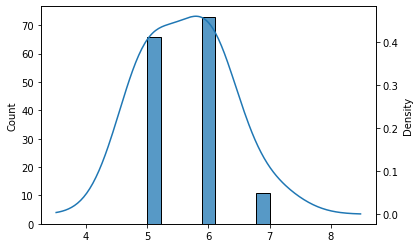

In [7]:
results = np.around(glm_model1.predict(dfVal))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.histplot(results, ax=ax1)
sns.kdeplot(results, ax=ax2, bw_method=0.8)

In [18]:
glm_metrics(glm_model1, dfVal, 'quality')

(4069.634888039317,
 0.5266666666666666,
 0.5266666666666666,
 0.52,
 Predicted  5.0  6.0  7.0
 True                    
 4            3    4    0
 5           40   20    2
 6           22   37    7
 7            1   12    1
 8            0    0    1,
       True  Predicted  RMSE  MAE
 idx                             
 4        5        5.0   0.0  0.0
 11       5        6.0   1.0  1.0
 15       5        5.0   0.0  0.0
 22       5        5.0   0.0  0.0
 24       6        5.0   1.0  1.0
 ...    ...        ...   ...  ...
 1580     6        6.0   0.0  0.0
 1581     5        6.0   1.0  1.0
 1585     6        6.0   0.0  0.0
 1594     5        6.0   1.0  1.0
 1598     6        6.0   0.0  0.0
 
 [150 rows x 4 columns])

In [13]:
## Model two
# https://stats.stackexchange.com/questions/190763/how-to-decide-which-glm-family-to-use
target = 'quality'
features = ['alcohol', 'sulphates']

formula = f'{target}~{"+".join(features)}'

glm_model2 = sm.GLM.from_formula(formula, 
                                 data = dfTrain, 
                                 family=sm.families.Poisson()).fit()

(aic, rmse, mae, acc, tab, results) = glm_metrics(glm_model2, dfVal, 'quality')

In [14]:
## Log Metrics and Model
mlflow.start_run()
mlflow.log_param("Input Features", features)
mlflow.log_metric("aic", aic)
mlflow.log_metric("rmse", rmse)
mlflow.log_metric("mae", mae)
mlflow.log_metric("acc", acc)

tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
if tracking_url_type_store != "file":
    mlflow.sklearn.log_model(glm_model2, "model", registered_model_name="GLM Wine Model")
else:
    mlflow.sklearn.log_model(glm_model2, "model")
mlflow.end_run()

Registered model 'GLM Wine Model' already exists. Creating a new version of this model...
2021/11/05 17:23:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: GLM Wine Model, version 2
Created version '2' of model 'GLM Wine Model'.


In [12]:
glm_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                quality   No. Observations:                 1107
Model:                            GLM   Df Residuals:                     1104
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2029.5
Date:                Fri, 05 Nov 2021   Deviance:                       88.172
Time:                        16:43:00   Pearson chi2:                     86.8
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9289      0.130      7.132      0.000       0.674       1.184
alcohol        0.0636      0.012      5.345      0.000       0.040       0.087
sulphates      0.2084      0.081      2.584      0.010       0.050       0.367
==============================================================================
"""

/home/portugapt/.pyenv/versions/3.8.1/envs/LearnHub/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/portugapt/.pyenv/versions/3.8.1/envs/LearnHub/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/portugapt/.pyenv/versions/3.8.1/envs/LearnHub/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


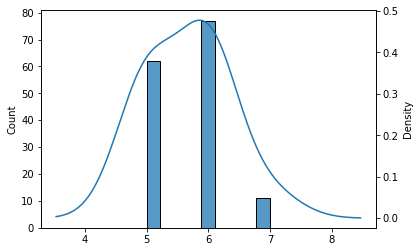

In [13]:
results = np.around(glm_model2.predict(dfVal))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.histplot(results, ax=ax1)
sns.kdeplot(results, ax=ax2, bw_method=0.8)

In [14]:
glm_metrics(glm_model2, dfVal, 'quality')

(4065.0868870366567,
 0.5,
 0.54,
 Predicted  5.0  6.0  7.0
 True                    
 4            3    4    0
 5           38   23    1
 6           20   40    6
 7            1   10    3
 8            0    0    1,
       True  Predicted  RMSE
 idx                        
 4        5        5.0   0.0
 11       5        6.0   1.0
 15       5        6.0   1.0
 22       5        6.0   1.0
 24       6        5.0   1.0
 ...    ...        ...   ...
 1580     6        6.0   0.0
 1581     5        6.0   1.0
 1585     6        6.0   0.0
 1594     5        6.0   1.0
 1598     6        6.0   0.0
 
 [150 rows x 3 columns])

In [121]:
glm_metrics(glm_model2, dfVal, 'quality')[3]

Predicted,5.0,6.0,7.0
True,,,
4,3,4,0
5,38,23,1
6,20,40,6
7,1,10,3
8,0,0,1
